## MULTI DAPI VAE in PYRO

### IMPORT NECESSARY MODULES

In [140]:
#!pip install pandas-profiling==1.4.0
#!pip install hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic

# !pip install corner
import corner

In [141]:
%matplotlib inline
import matplotlib.pyplot as plt

from LOW_LEVEL_UTILITIES.utilities import show_batch, save_obj, load_obj 
from LOW_LEVEL_UTILITIES.utilities import load_json_as_dict, save_dict_as_json

import numpy as np
import torch
import pyro

# Get the data

In [142]:
LOCAL_MACHINE=False
if LOCAL_MACHINE:
    BATCH_SIZE = 4
    data_dir = "/Users/ldalessi/DAPI_unsupervised/DATA/" # for local machine
    write_dir  = '/Users/ldalessi/DAPI_unsupervised/spacetx-research/ARCHIVE/' # local machine
    reference_dir = '/Users/ldalessi/DAPI_unsupervised/DATA/'
else:
    BATCH_SIZE = 128
    data_dir = "/home/jupyter/REPOS/spacetx-research/DATA/" # for VM t4
    #write_dir  = '/home/jupyter/REPOS/spacetx-research/ARCHIVE/' # V4
    write_dir  = '/home/jupyter/REPOS/spacetx-research/NEW_ARCHIVE/' # V4
    reference_dir = '/home/jupyter/REPOS/spacetx-research/DATA/REFERENCES/'
    


# Utility functions

In [143]:
def add_to_dict(dictionary,key,value):
    try:
        dictionary[key].append(value)
    except:
        dictionary[key] = [value]
    return dictionary

def create_dict_from_trials(Trials):
    my_dict, my_dict_good = {}, {}
    
    for t in Trials.trials:
        inputs = t['misc']['vals']
        outputs = t['result']['history']
        good = True if outputs['accuracy'][-1] > 0.5 else False
    
        for key,v in outputs.items():
            if key == 'accuracy' or key == 'difference' or key == 'difference_abs':
                val = v[-1]
                add_to_dict(my_dict,key,val)
                if good:
                    add_to_dict(my_dict_good,key,val)
                        
        for key,v in inputs.items():
            
            val = v[-1] if (key == 'x_logit_mu' or key == 'x_logit_std') else np.log(v[-1])
            add_to_dict(my_dict,key,val)
            if good:
                add_to_dict(my_dict_good,key,val)
                
    return my_dict, my_dict_good

def make_nupy_array_from_dict(dictionary=None):
    """ make a numpy array of size [nsamples, ndim] starting from a dictionary
        with ndim keywords each associated to a list of nsamples values """
    
    list_of_keys = []
    ndim = len(dictionary.keys())
    first_time=True
    for k,v in dictionary.items():
        tmp = np.asarray(v, dtype=float).reshape(-1,1)
        if first_time:
            data = tmp
            first_time=False
            list_of_keys = [k]
        else:
            data = np.concatenate((data,tmp),axis=1)
            list_of_keys.append(k)
    return data, list_of_keys

In [153]:
# Load old trial
Trials = load_obj(write_dir, "hyper_opt_sweep_v3")
print(len(Trials.trials))

#dict_outputs = trials.trials[0]['result']['history']
#dict_inputs =trials.trials[0]['misc']['vals']
#print("outputs ->",dict_outputs.keys())
#print("inputs ->",dict_inputs.keys())

21


avg best error: 19.0


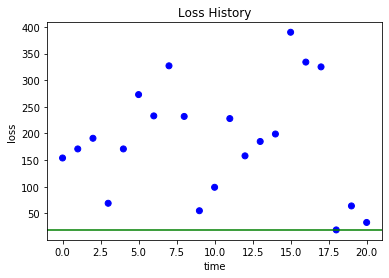

In [154]:
from hyperopt.plotting import main_plot_history,  main_plot_histogram, main_plot_vars
main_plot_history(Trials)

Showing Histogram of 21 jobs


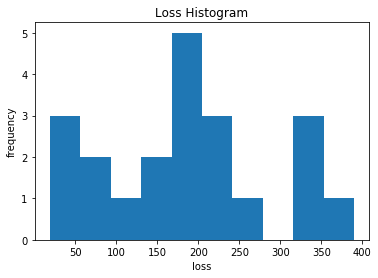

In [155]:
main_plot_histogram(Trials)

finite loss range 19.0 390.0 18.0


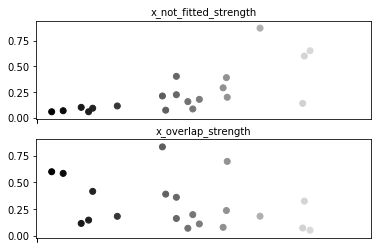

In [156]:
main_plot_vars(Trials, 
               columns=1,
               arrange_by_loss=True)

# See corner plots

In [159]:
Trials.best

AttributeError: 'Trials' object has no attribute 'best'

In [157]:
my_dict, my_dict_good = create_dict_from_trials(Trials)

In [158]:
my_dict

{'accuracy': [0.6328125,
  0.6067708333333334,
  0.5572916666666666,
  0.8333333333333334,
  0.6067708333333334,
  0.4166666666666667,
  0.4791666666666667,
  0.3411458333333333,
  0.4791666666666667,
  0.8645833333333334,
  0.7552083333333334,
  0.4869791666666667,
  0.6354166666666666,
  0.5703125,
  0.5494791666666666,
  0.24739583333333334,
  0.3255208333333333,
  0.3359375,
  0.9505208333333334,
  0.8385416666666666,
  0.9140625],
 'difference': [150.0,
  171.0,
  189.0,
  65.0,
  169.0,
  273.0,
  229.0,
  327.0,
  232.0,
  51.0,
  95.0,
  226.0,
  156.0,
  183.0,
  197.0,
  390.0,
  334.0,
  325.0,
  9.0,
  54.0,
  31.0],
 'difference_abs': [154.0,
  171.0,
  191.0,
  69.0,
  171.0,
  273.0,
  233.0,
  327.0,
  232.0,
  55.0,
  99.0,
  228.0,
  158.0,
  185.0,
  199.0,
  390.0,
  334.0,
  325.0,
  19.0,
  64.0,
  33.0],
 'x_not_fitted_strength': [-1.5591554131283214,
  -1.502337135452763,
  -2.479608585142344,
  -2.395272534493737,
  -0.9116459430521231,
  -0.13781803209567342,


In [150]:
data, list_keys = make_nupy_array_from_dict(my_dict)
data_good, list_keys_good = make_nupy_array_from_dict(my_dict_good)

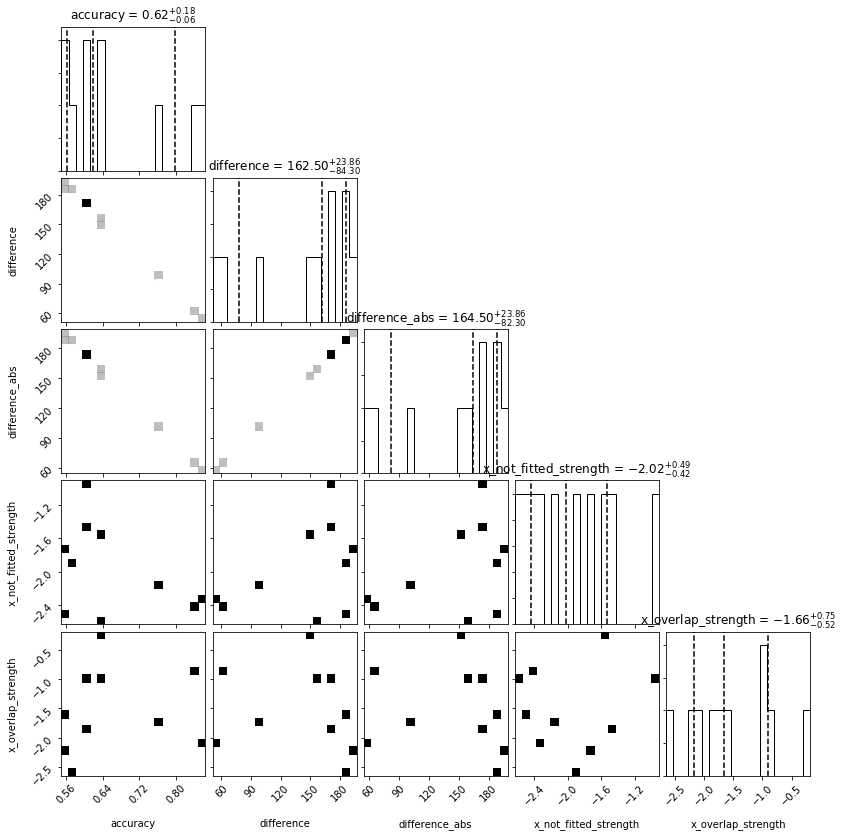

In [151]:
figure_good = corner.corner(data_good, labels=list_keys_good,
                            quantiles=[0.16, 0.5, 0.84],
                            plot_contours = False,
                            show_titles=True, title_kwargs={"fontsize": 12})

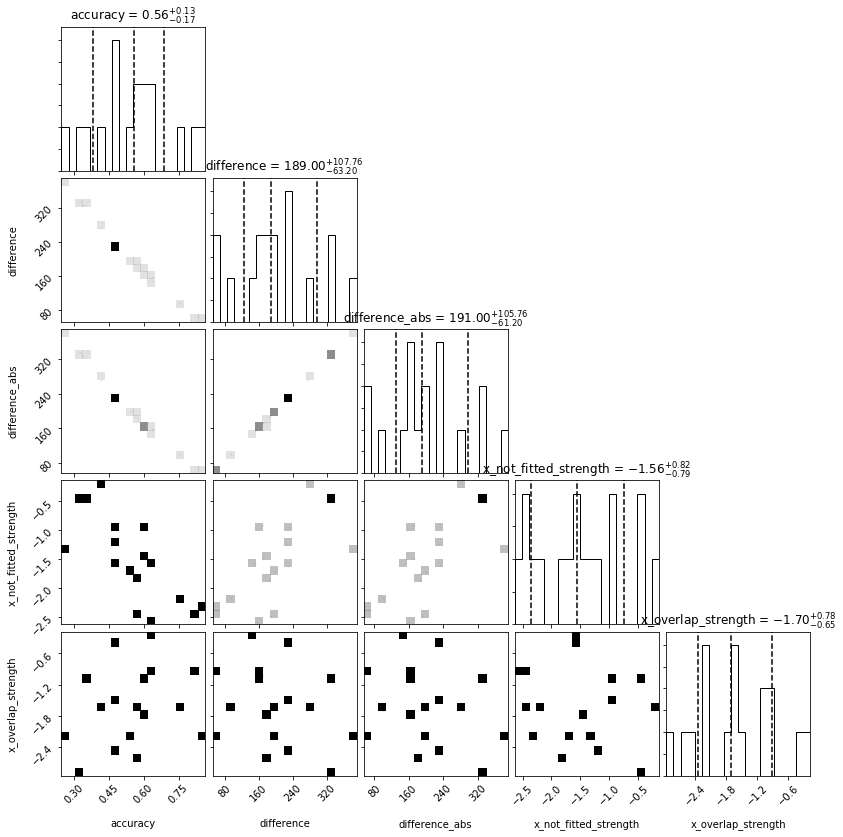

In [165]:
figure = corner.corner(data, labels=list_keys,
                       quantiles=[0.16, 0.5, 0.84],
                       plot_contours = False,
                       show_titles=True, title_kwargs={"fontsize": 12})

# Plot the best results

In [160]:
Trials.best_trial

{'state': 2,
 'tid': 18,
 'spec': None,
 'result': {'loss': 19.0,
  'status': 'ok',
  'history': {'train_loss': [301.19248860677084,
    -1876.9902425130208,
    -2230.4978271484374,
    -2806.855924479167,
    -3060.324609375,
    -3203.9296061197915,
    -3304.814208984375,
    -3398.965787760417,
    -3434.1078125,
    -3509.881136067708,
    -3602.208447265625,
    -3674.120914713542,
    -3744.6177571614585,
    -3813.8269205729166,
    -3868.9864583333333,
    -3922.20078125,
    -3973.54638671875,
    -4031.8853352864585,
    -4122.951416015625,
    -4221.597119140625,
    -4350.26474609375,
    -4550.981640625,
    -4668.192708333333,
    -5052.170638020833,
    -5336.724381510417,
    -5483.812272135417,
    -5584.9025390625,
    -5663.58330078125,
    -5684.019596354166,
    -5734.472135416667,
    -5793.5046875,
    -5819.036393229167,
    -5859.461555989584,
    -5878.167936197917,
    -5933.623307291667,
    -5995.91396484375,
    -6021.956184895834,
    -6045.53310546875,

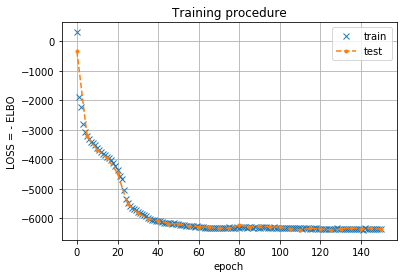

In [161]:
history_dict = Trials.best_trial['result']['history']
TEST_FREQUENCY = 5
#plt.yscale('log')
y_shift=0
x_shift=0
sign=1
plt.plot(np.arange(x_shift, x_shift+len(history_dict["train_loss"])), sign*np.array(history_dict["train_loss"])+y_shift,'x')
plt.plot(np.arange(x_shift, x_shift+len(history_dict["test_loss"])*TEST_FREQUENCY,TEST_FREQUENCY), sign*np.array(history_dict["test_loss"])+y_shift, '.--')
plt.xlabel('epoch')
plt.ylabel('LOSS = - ELBO')
plt.title('Training procedure')
#plt.ylim(ymin = -10000, ymax=-4000)
plt.grid(True)
plt.legend(['train', 'test'])
#plt.show()

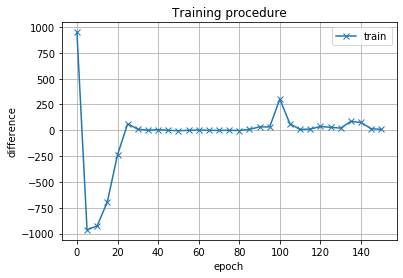

In [162]:
y_shift=0
x_shift=0
sign=1
plt.plot(np.arange(0, len(history_dict["difference"])*TEST_FREQUENCY, TEST_FREQUENCY),history_dict["difference"],'x-')
plt.xlabel('epoch')
plt.ylabel('difference')
plt.title('Training procedure')
#plt.ylim(ymin = -10000, ymax=-4000)
plt.grid(True)
plt.legend(['train', 'test'])
#plt.show()

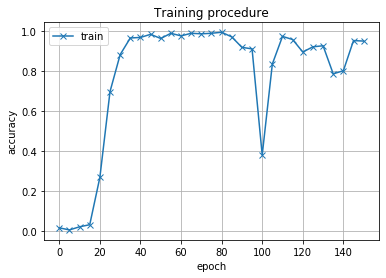

In [163]:
#plt.yscale('log')
y_shift=0
x_shift=0
sign=1
plt.plot(np.arange(0, len(history_dict["accuracy"])*TEST_FREQUENCY, TEST_FREQUENCY),history_dict["accuracy"],'x-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training procedure')
#plt.ylim(ymin = -10000, ymax=-4000)
plt.grid(True)
plt.legend(['train', 'test'])
#plt.show()

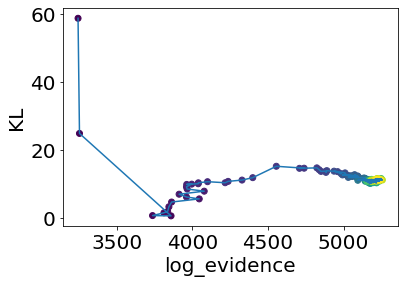

In [164]:
# Plot of KL vs evidence
fontsize=20
labelsize=20

scale= 1
N = len(history_dict["log_evidence_total"])
colors = np.arange(0.0,N,1.0)/N

plt.xlabel('log_evidence',fontsize=fontsize)
plt.ylabel('KL',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=labelsize)
plt.scatter(history_dict["log_evidence_total"], history_dict["kl_total"],c=colors)
plt.plot(history_dict["log_evidence_total"], history_dict["kl_total"], '-')
plt.show()